In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

In [3]:
# Import src functions
sys.path.insert(0, src_folder)
from modeling import *
from stats_and_visualisations import *
from s3_storage import *

In [4]:
### ---- PARAMETERS
iterations_per_model = 2

In [5]:
# Import data
X_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_train.npy')
X_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_test.npy')
y_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_train.npy')
y_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_test.npy')
print('--> Importing done')

--> Importing done


## Logistic regression

In [6]:
# Create temporary training and validation sets
X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
# Define training function
def train_logistic(X_train, X_test, y_train, y_test):

    clf = LogisticRegression(random_state=0,
                             solver='lbfgs',
                             class_weight='balanced').fit(X_train, y_train)

    train_predict = clf.predict_proba(X_train)
    test_predict = clf.predict_proba(X_test)

    train_score = roc_auc_score(y_train, train_predict[:,1])
    test_score = roc_auc_score(y_test, test_predict[:,1])

    print('Logistic Train', train_score)
    print('Logistic Test', test_score)
    
    return train_score, test_score, clf

In [8]:
train_score, test_score, logistic_model = train_logistic(X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp)

Logistic Train 0.8475897768941401
Logistic Test 0.8307833607155896


In [9]:
# Save model as Pickle
to_s3(obj=logistic_model, bucket='mimic-jamesi', filepath='models/logistic_regression')

## Define functions

In [10]:
def run_random_search(model, random_grid, scoring, cv, n_iter, X_train, y_train):
    
    # Use the random grid to search for best hyperparameters
    m = model
    print('--> Model defined')

    random_search_model = RandomizedSearchCV(estimator = m, scoring=scoring,
                                   param_distributions = random_grid,
                                   n_iter = n_iter, cv = cv, verbose=0,
                                   random_state=8, n_jobs = -1,
                                   return_train_score=True)
    print('--> Random search defined')

    # Fit the random search model
    random_search_model.fit(X_train, y_train)
    print('--> Fitting done')

    # Print the best CV score
    print('--> Best CV Score: ', random_search_model.best_score_)
    
    return random_search_model

In [11]:
def visualise_results(random_grid, random_search_model, training_score, cv_score, fit_time):
    
    # Clean the CV results df, keeping only columns that are needed
    keep_cols = ['param_{}'.format(param) for param in random_grid.keys()]
    keep_cols = keep_cols + [training_score, cv_score, fit_time]
    results = pd.DataFrame(random_search_model.cv_results_)[keep_cols]

    # Visualise best CV score by run
    best_cv_by_run(results, cv_score)

    # Visualise the scores by single hyperparameters
    plot_single_results(results, training_score, cv_score, fit_time)

    # Visualise the scores by double hyperparameters
    plot_double_results(results, [training_score, cv_score, fit_time])

    results.sort_values(by=cv_score, ascending=False, inplace=True)
    
    return results

In [12]:
def final_run(random_search_model, classifier, model_name):
    
    # Find the best parameters
    best_params=random_search_model.best_params_
    
    # Create the model
    model = classifier(**best_params)

    # Train the model
    model.fit(X_train, y_train)
    
    # Save model
    to_s3(obj=model, bucket='mimic-jamesi', filepath='models/{}'.format(model_name))

## Decision tree

In [13]:
# define the grid search parameters
criterion = ['gini', 'entropy']
class_weight = ['balanced']
max_features = list(np.arange(2, X_train.shape[1]))
max_depth = list(np.arange(1, 100))
max_depth.append(None)
min_samples_split = list(np.arange(2, 250))
min_samples_leaf = list(np.arange(1, 250))

# Create the random grid
dt_random_grid = {'criterion': criterion,
                  'class_weight': class_weight,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

print('--> Grid defined')

--> Grid defined


In [14]:
# Run the random search model
dt_random_search_model = run_random_search(model=DecisionTreeClassifier(), random_grid=dt_random_grid,
                                        scoring='roc_auc', cv=5, n_iter=iterations_per_model, 
                                        X_train=X_train, y_train=y_train)

--> Model defined
--> Random search defined
--> Fitting done
--> Best CV Score:  0.8430165990595035


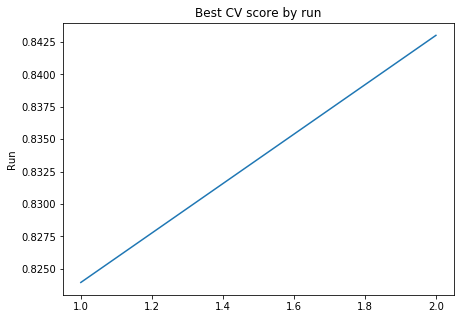

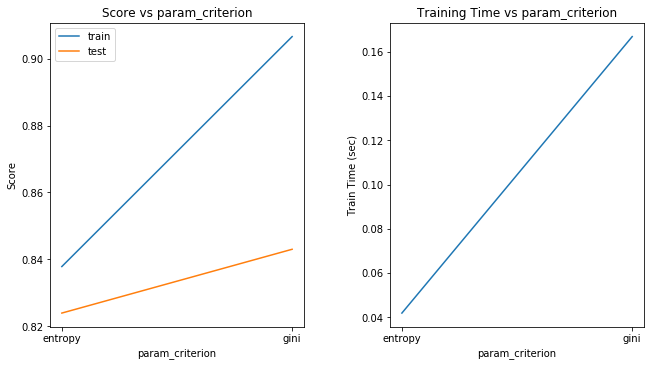

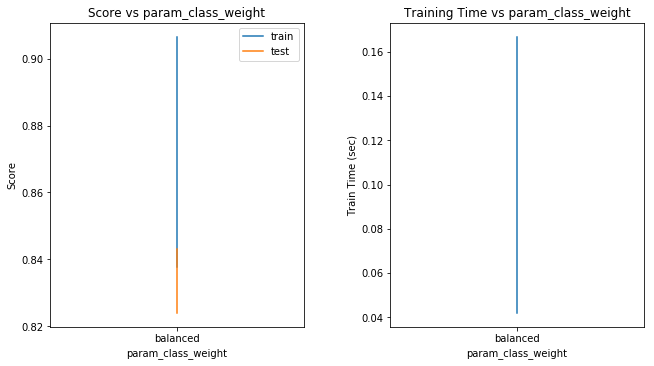

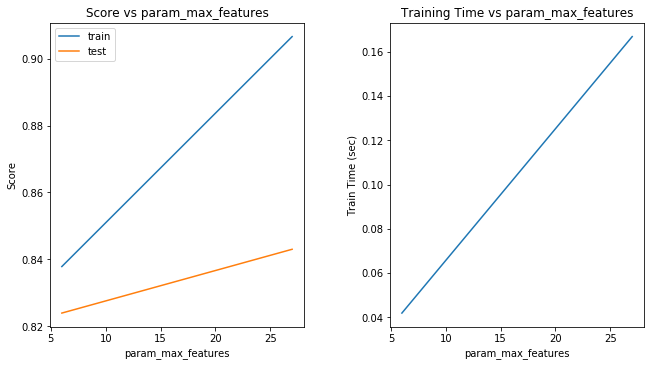

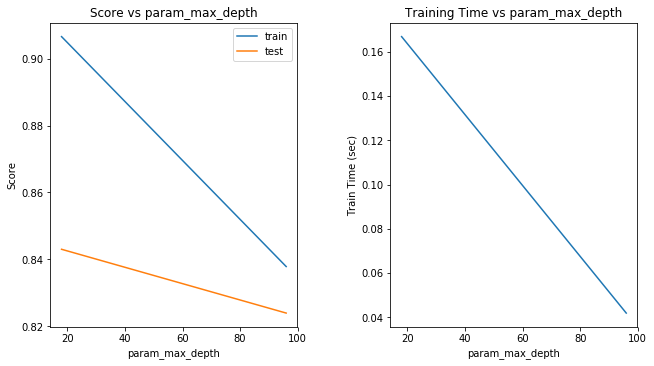

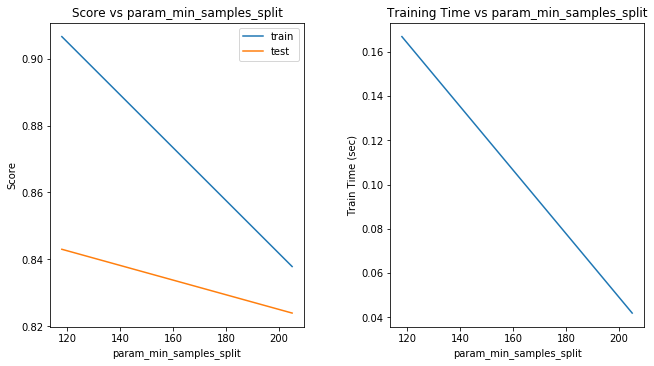

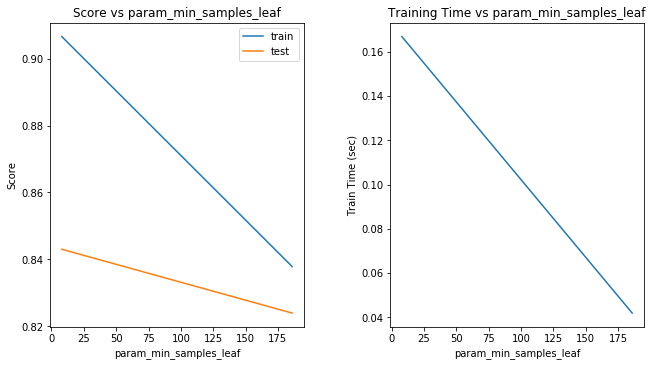

param_criterion and param_class_weight


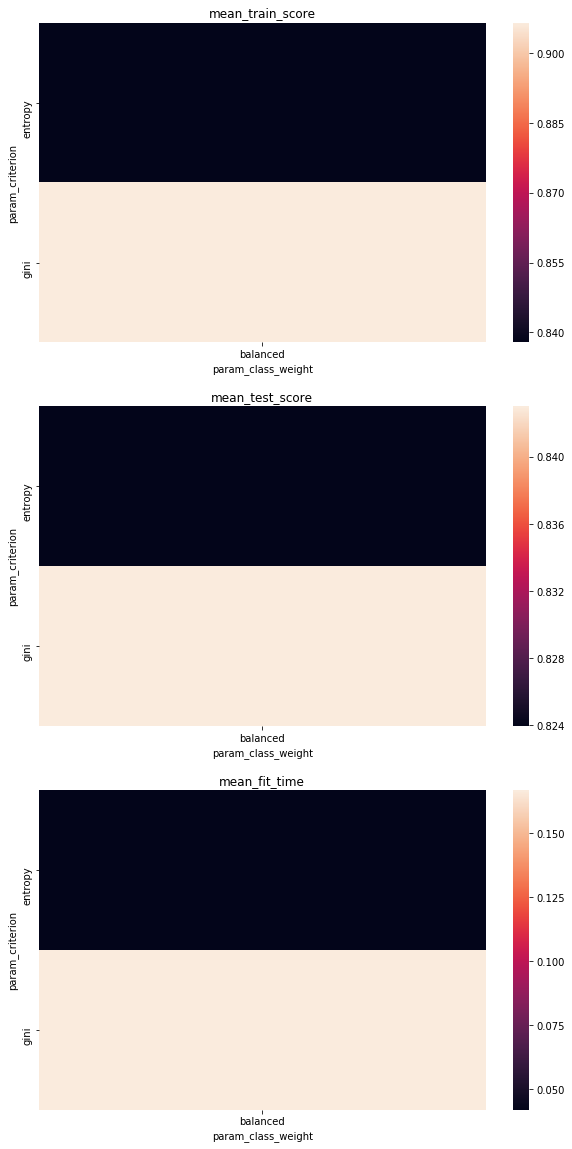


param_criterion and param_max_features


<Figure size 432x288 with 0 Axes>

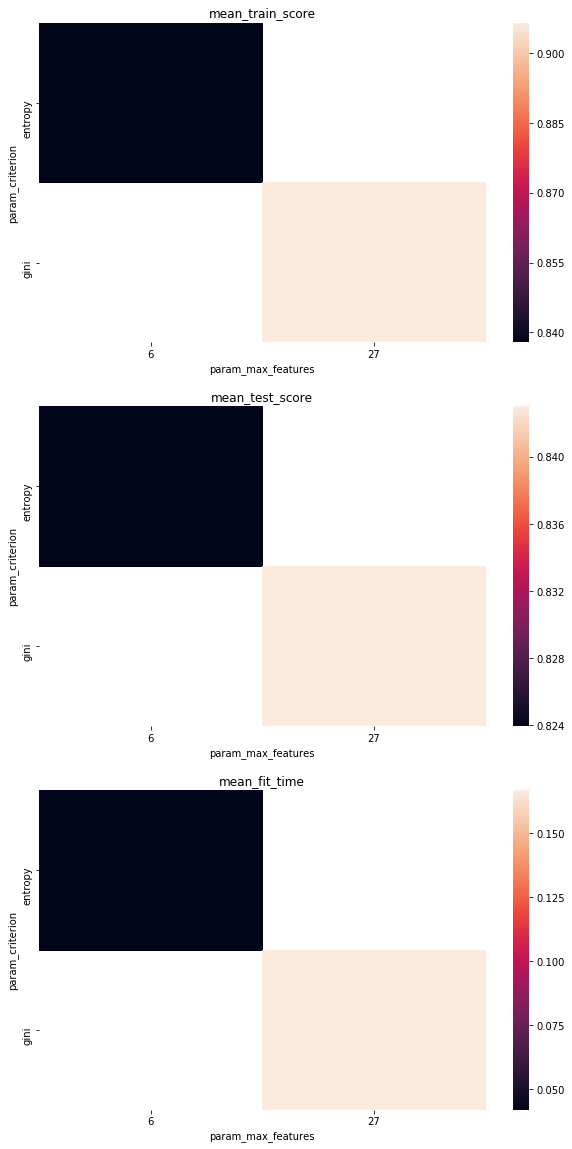


param_criterion and param_max_depth


<Figure size 432x288 with 0 Axes>

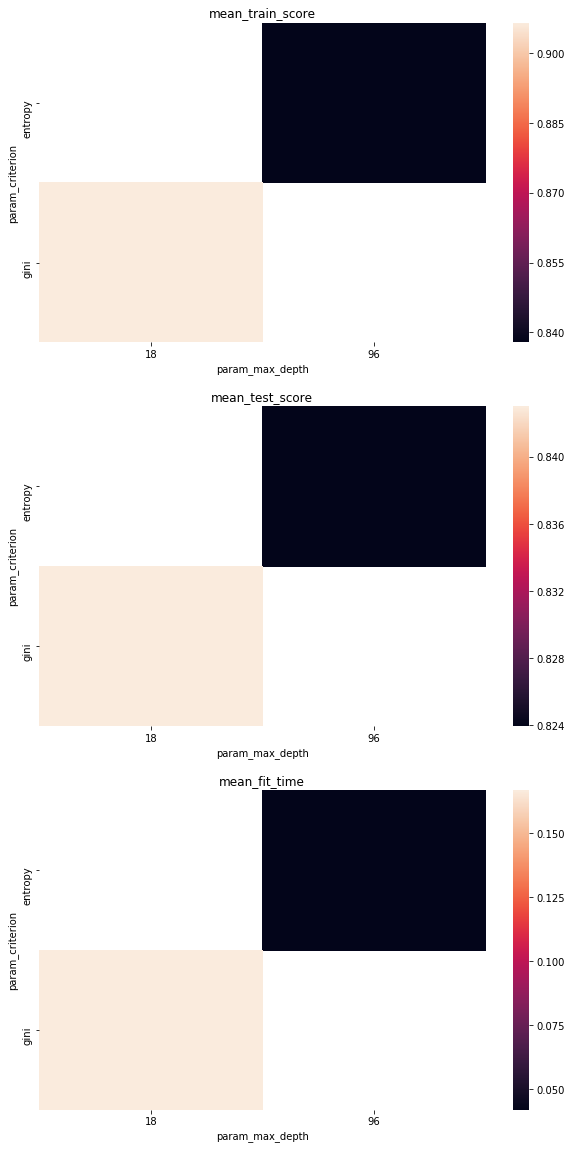


param_criterion and param_min_samples_split


<Figure size 432x288 with 0 Axes>

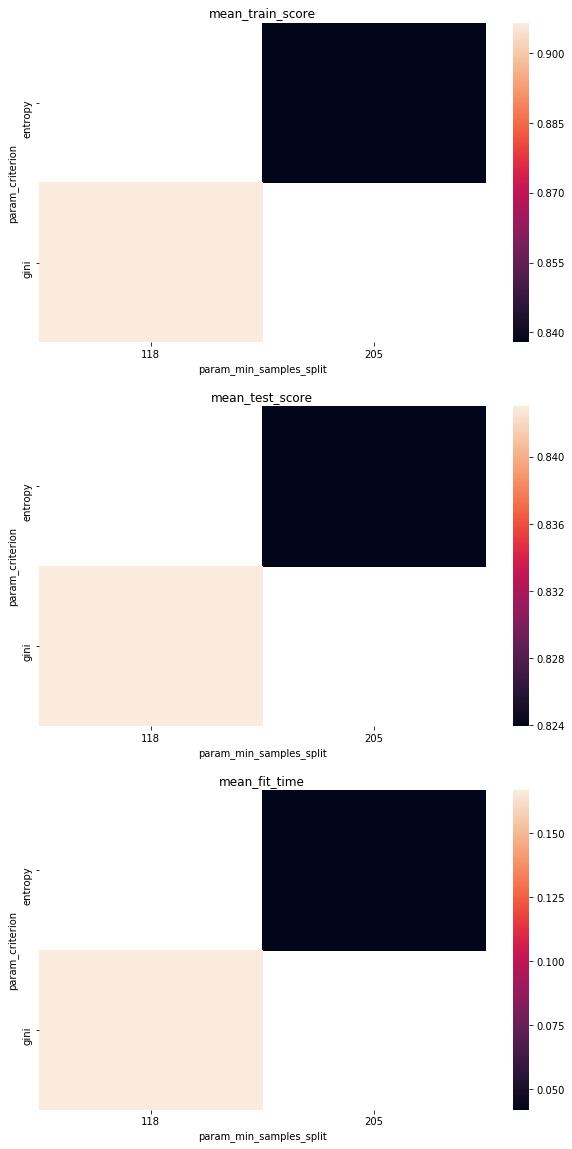


param_criterion and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

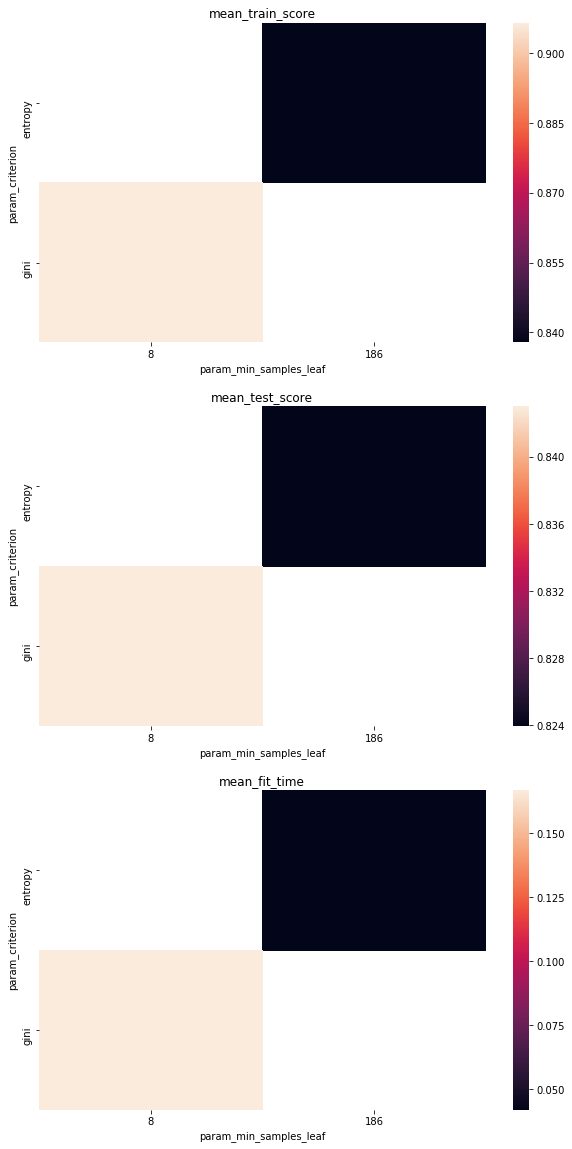


param_class_weight and param_max_features


<Figure size 432x288 with 0 Axes>

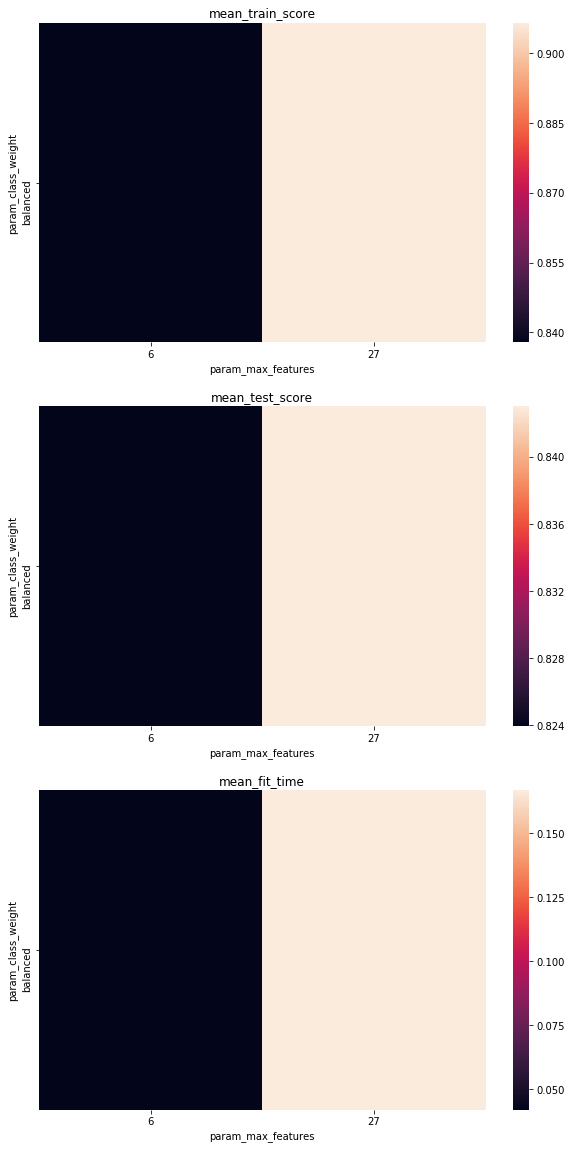


param_class_weight and param_max_depth


<Figure size 432x288 with 0 Axes>

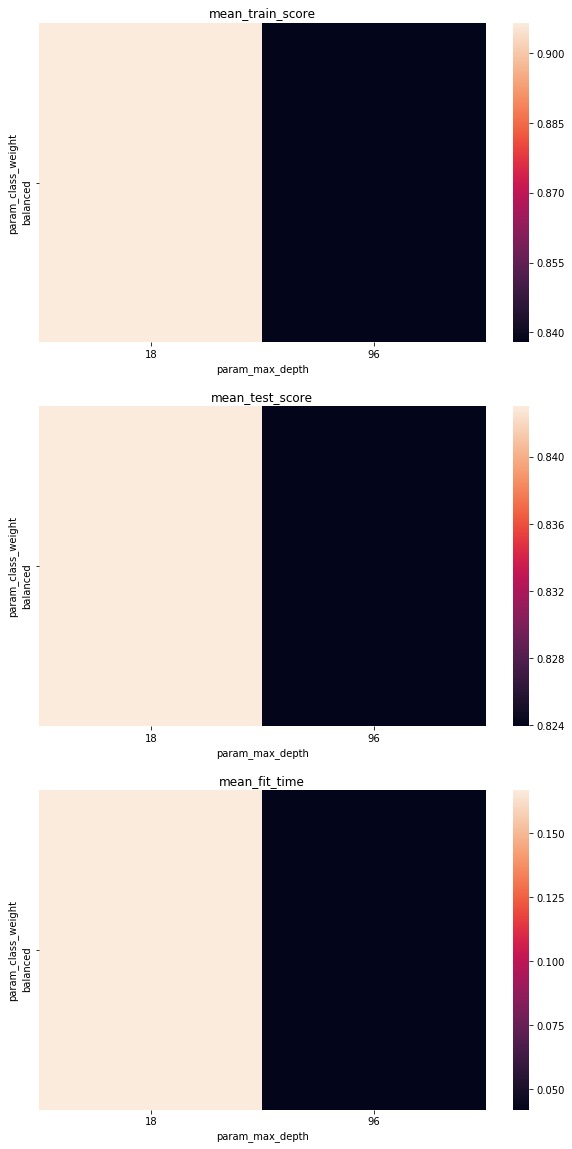


param_class_weight and param_min_samples_split


<Figure size 432x288 with 0 Axes>

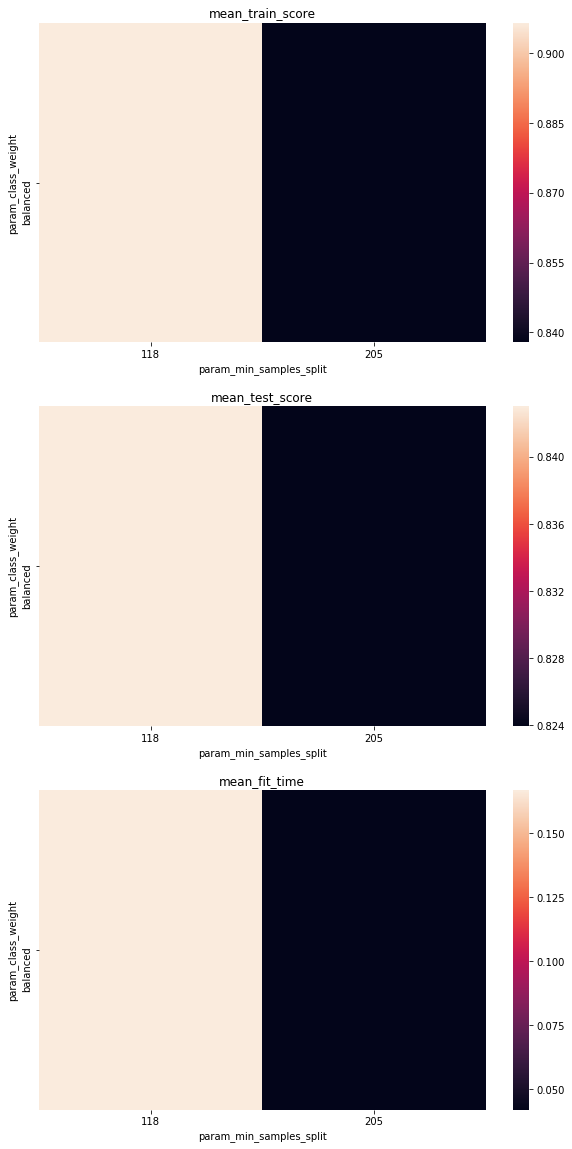


param_class_weight and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

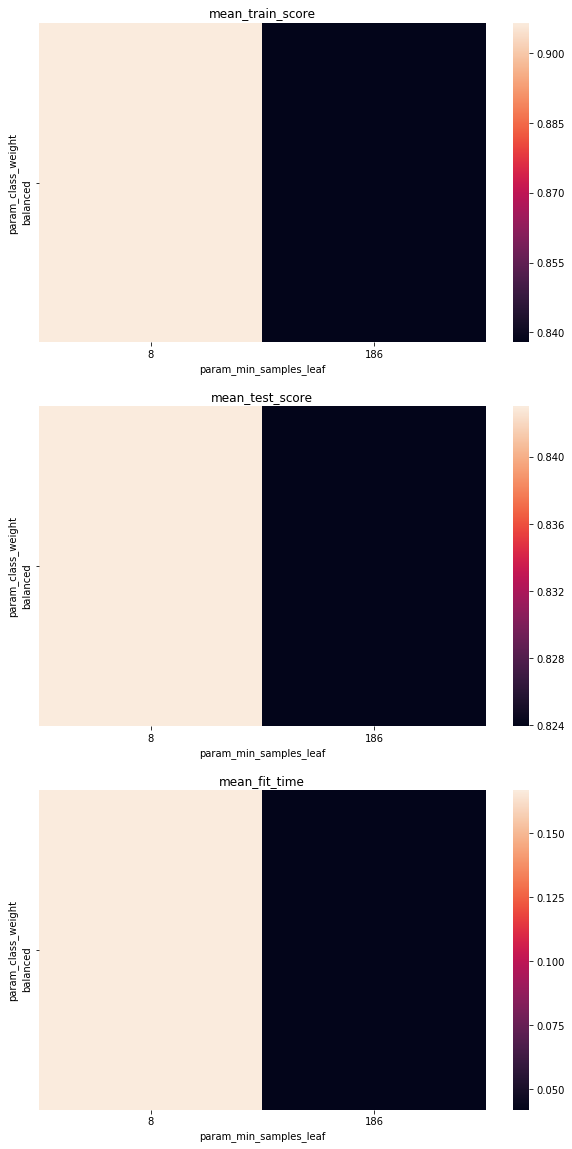


param_max_features and param_max_depth


<Figure size 432x288 with 0 Axes>

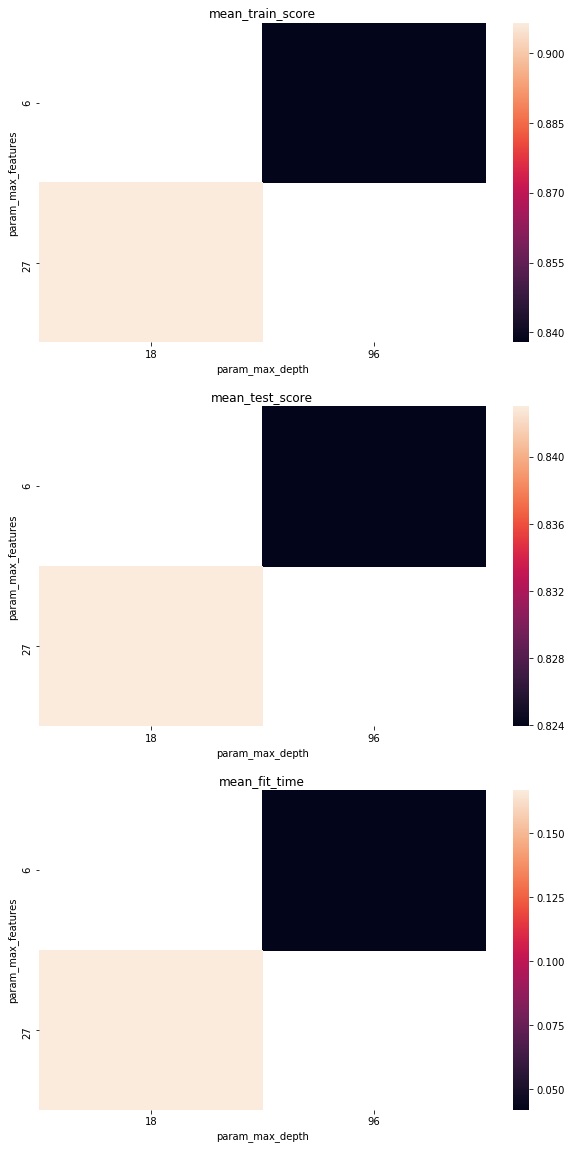


param_max_features and param_min_samples_split


<Figure size 432x288 with 0 Axes>

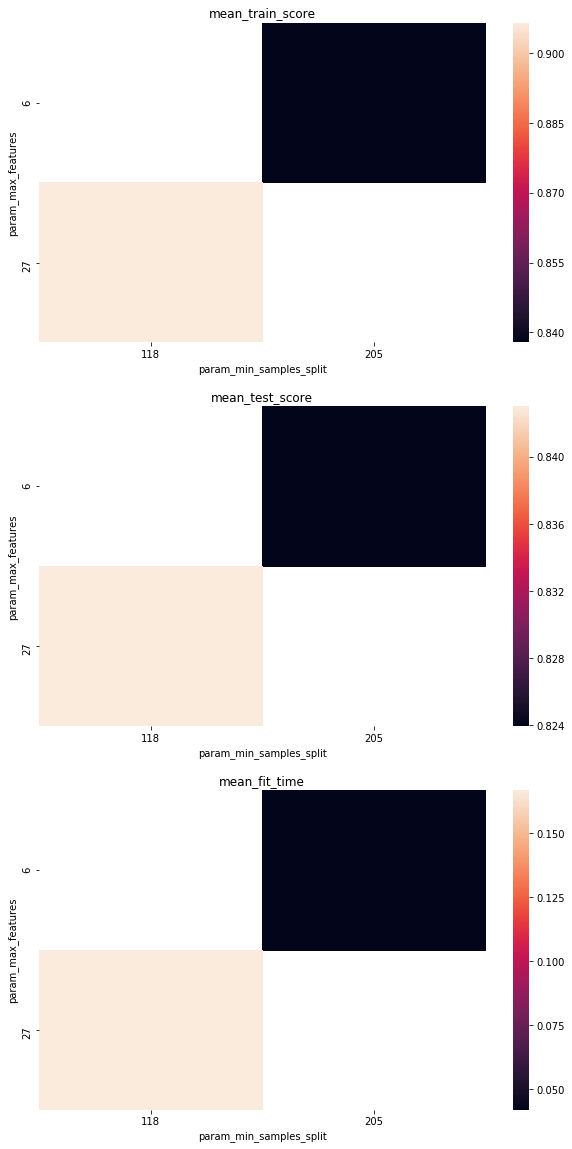


param_max_features and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

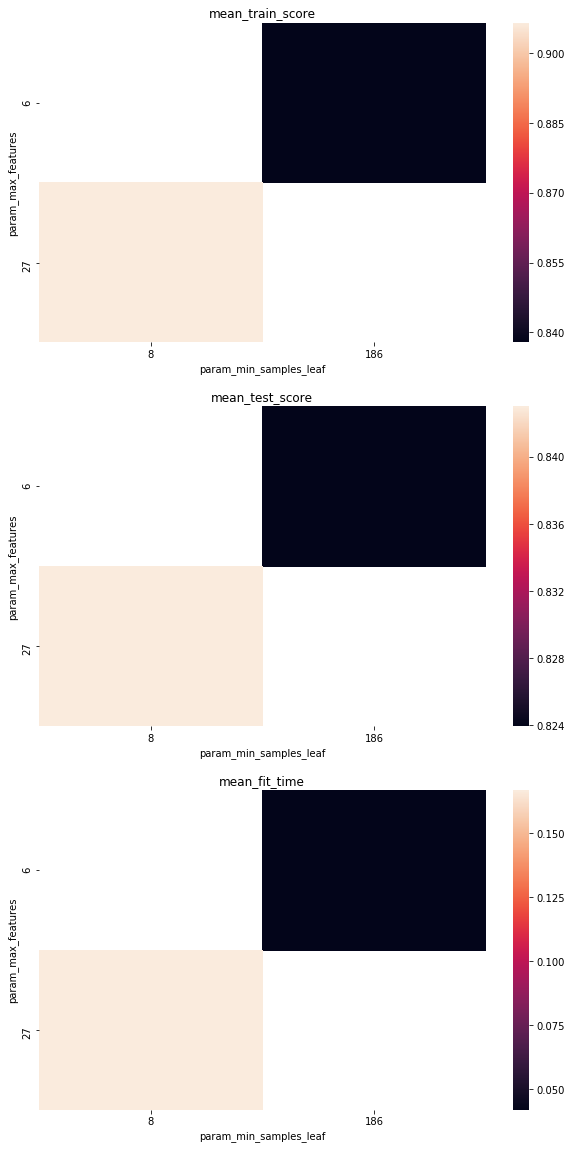


param_max_depth and param_min_samples_split


<Figure size 432x288 with 0 Axes>

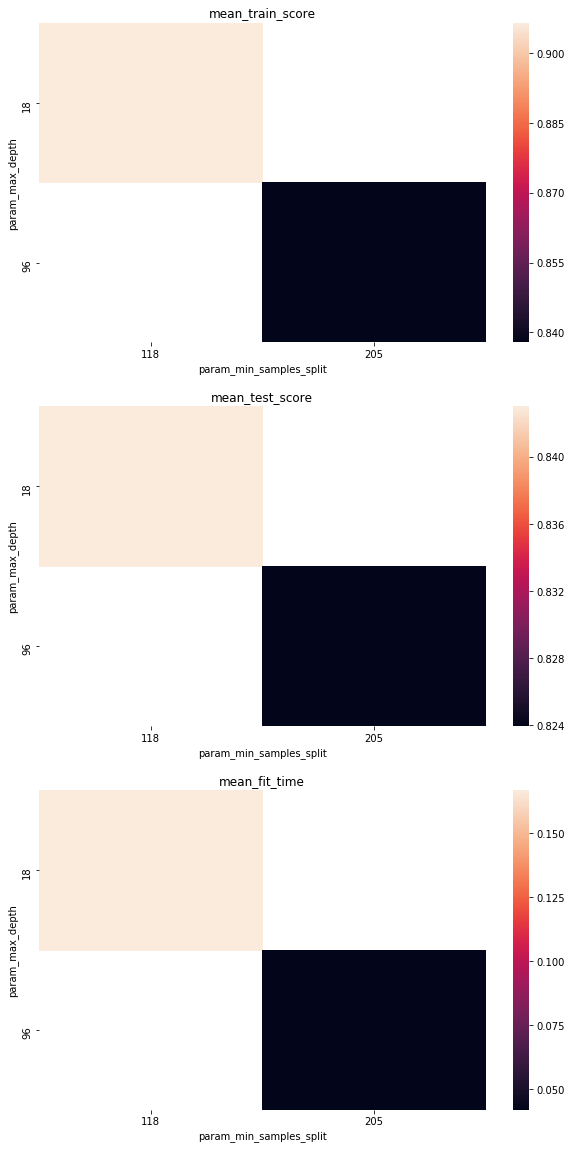


param_max_depth and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

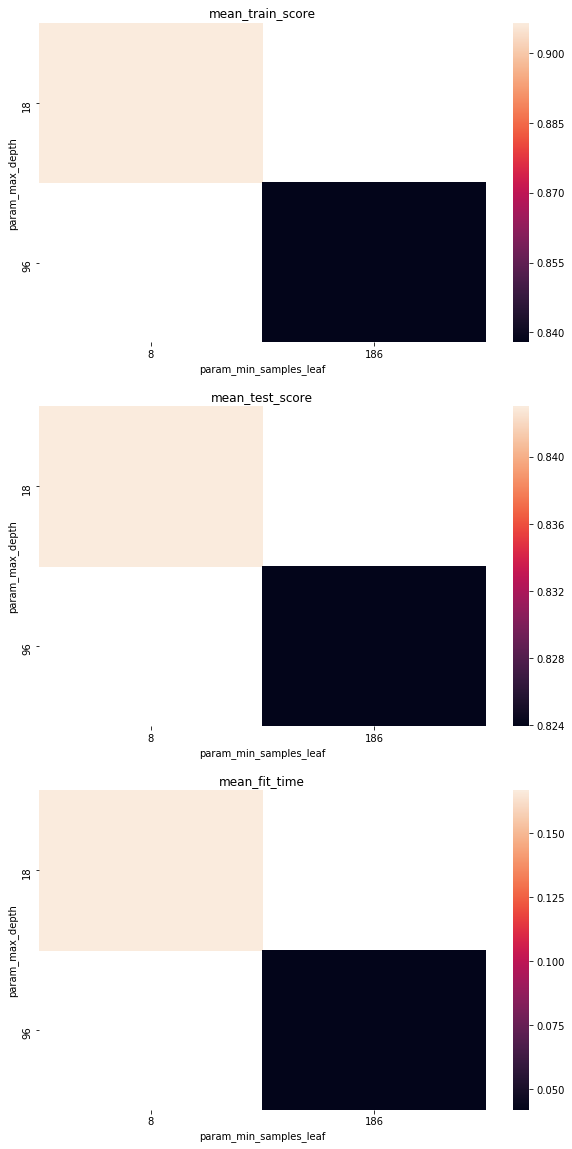


param_min_samples_split and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

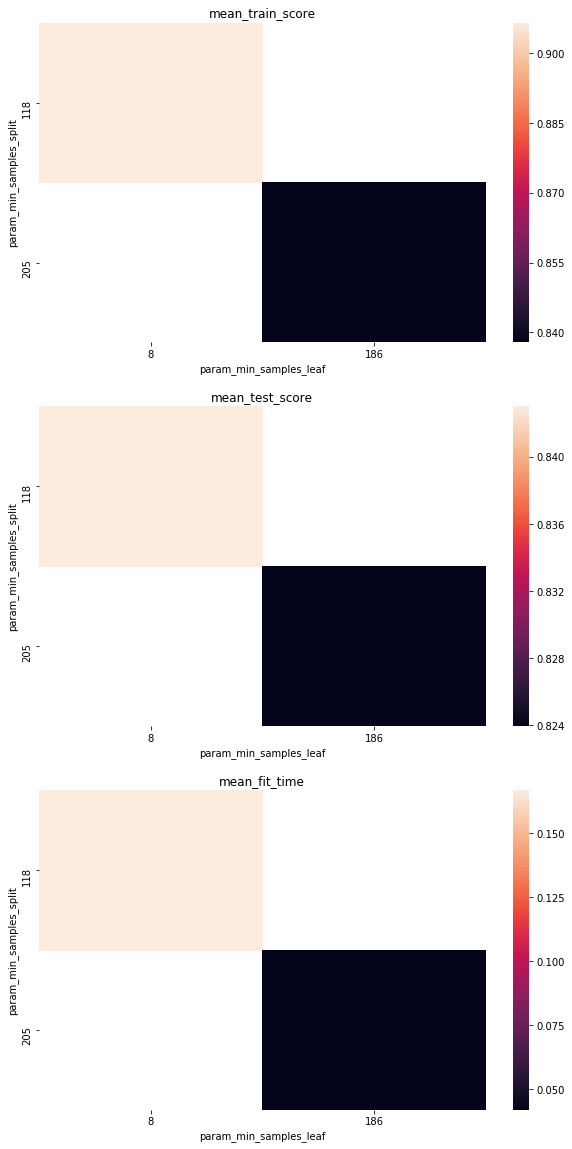

,param_criterion,param_class_weight,param_max_features,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
1,gini,balanced,27,18,118,8,0.906591,0.843017,0.166812
0,entropy,balanced,6,96,205,186,0.837857,0.823946,0.041941


<Figure size 432x288 with 0 Axes>

In [15]:
# Visualise the results to find optimal hyperparameters
dt_results = visualise_results(random_grid=dt_random_grid, random_search_model=dt_random_search_model,
                            training_score='mean_train_score', cv_score='mean_test_score', fit_time='mean_fit_time')
dt_results

In [16]:
# Re-run on best parameters and save model
final_run(random_search_model=dt_random_search_model,
          classifier=DecisionTreeClassifier,
          model_name='decision_tree')

## Random Forest

In [17]:
# define the grid search parameters
n_estimators = list(np.arange(20, 3000, 5))
max_features = list(np.arange(2, X_train.shape[1]))
max_depth = list(np.arange(1, 100))
max_depth.append(None)
min_samples_split = list(np.arange(2, 250))
min_samples_leaf = list(np.arange(1, 250))
bootstrap = [True, False]

# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

print('--> Grid defined')

--> Grid defined


In [18]:
# Run the random search model
rf_random_search_model = run_random_search(model=RandomForestClassifier(), random_grid=rf_random_grid,
                                        scoring='roc_auc', cv=5, n_iter=iterations_per_model, 
                                        X_train=X_train, y_train=y_train)

--> Model defined
--> Random search defined
--> Fitting done
--> Best CV Score:  0.8715731948025238


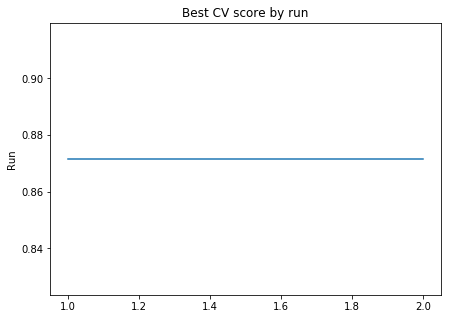

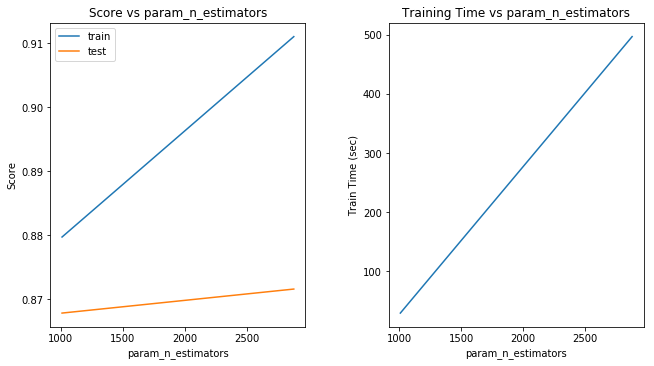

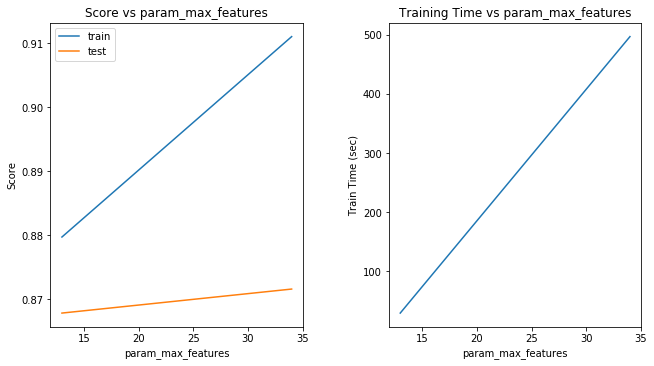

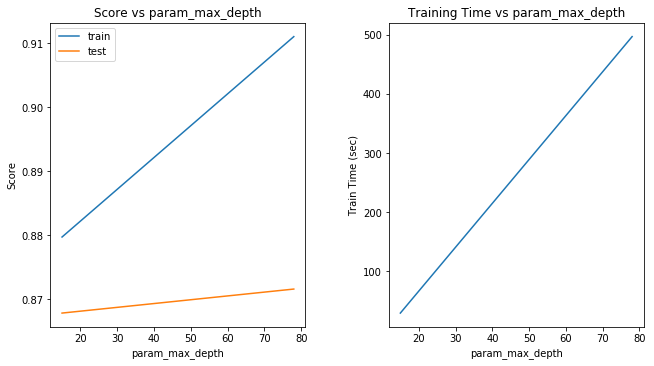

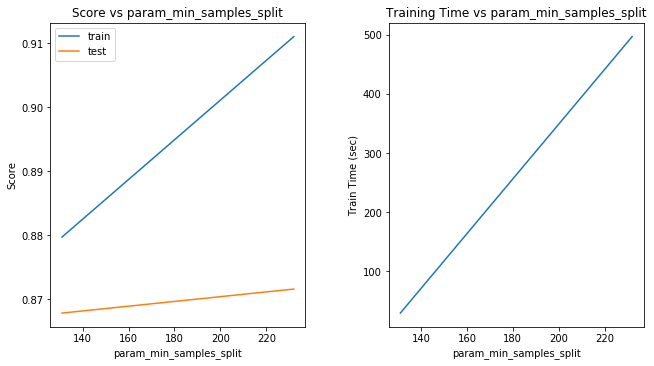

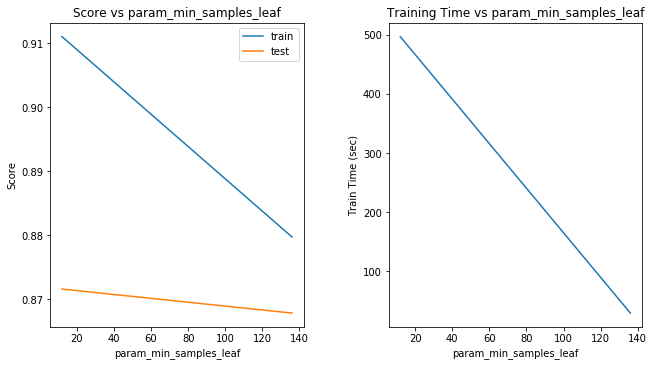

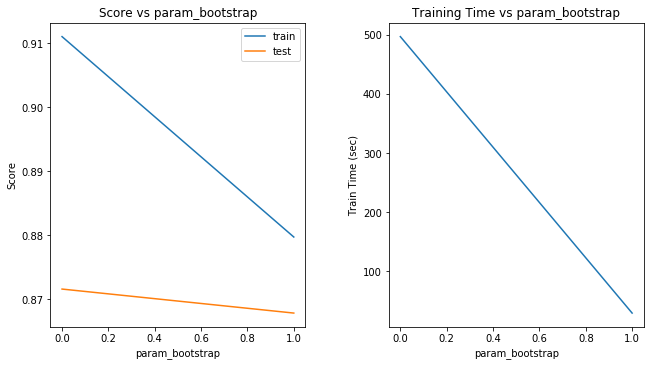

param_n_estimators and param_max_features


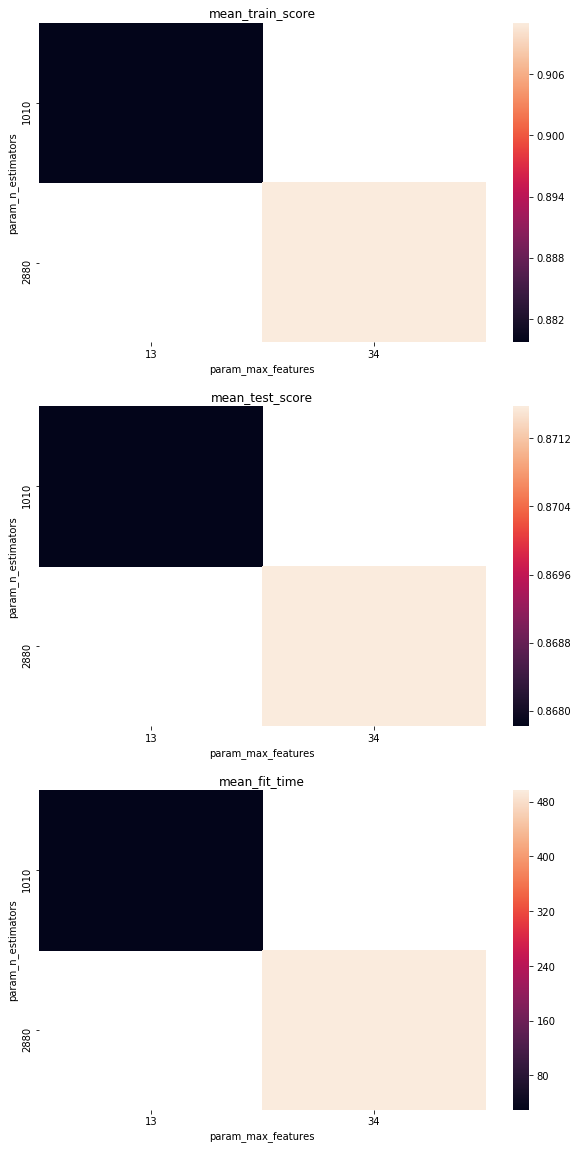


param_n_estimators and param_max_depth


<Figure size 432x288 with 0 Axes>

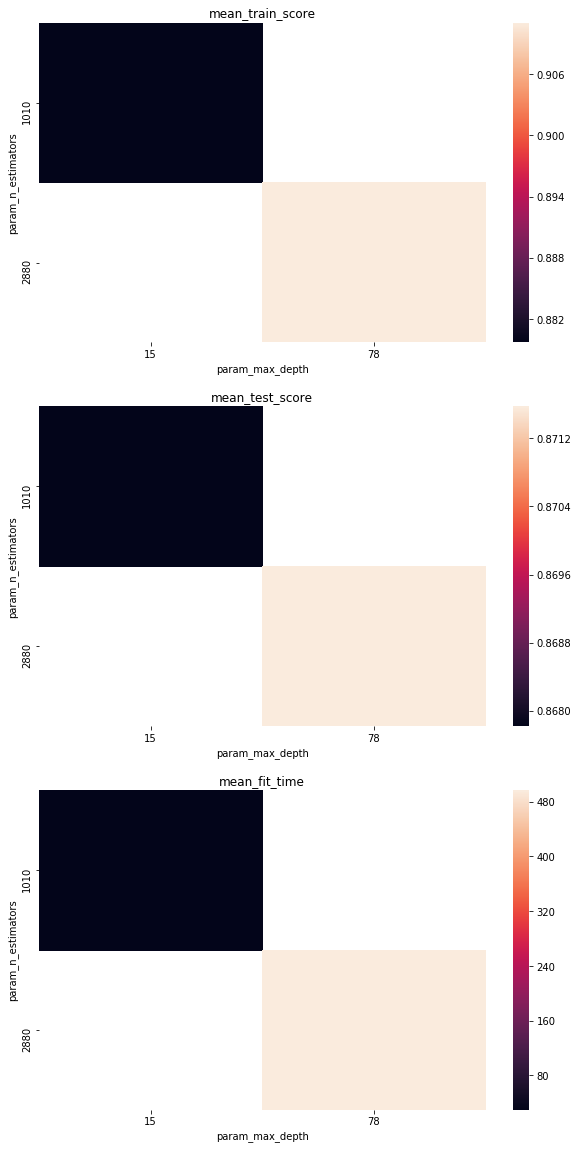


param_n_estimators and param_min_samples_split


<Figure size 432x288 with 0 Axes>

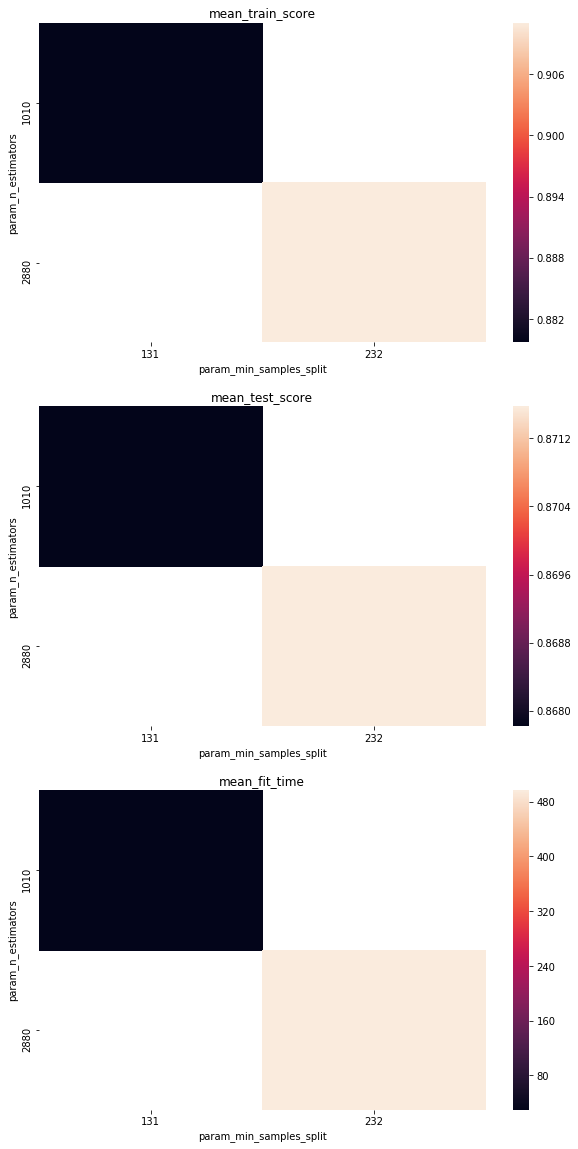


param_n_estimators and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

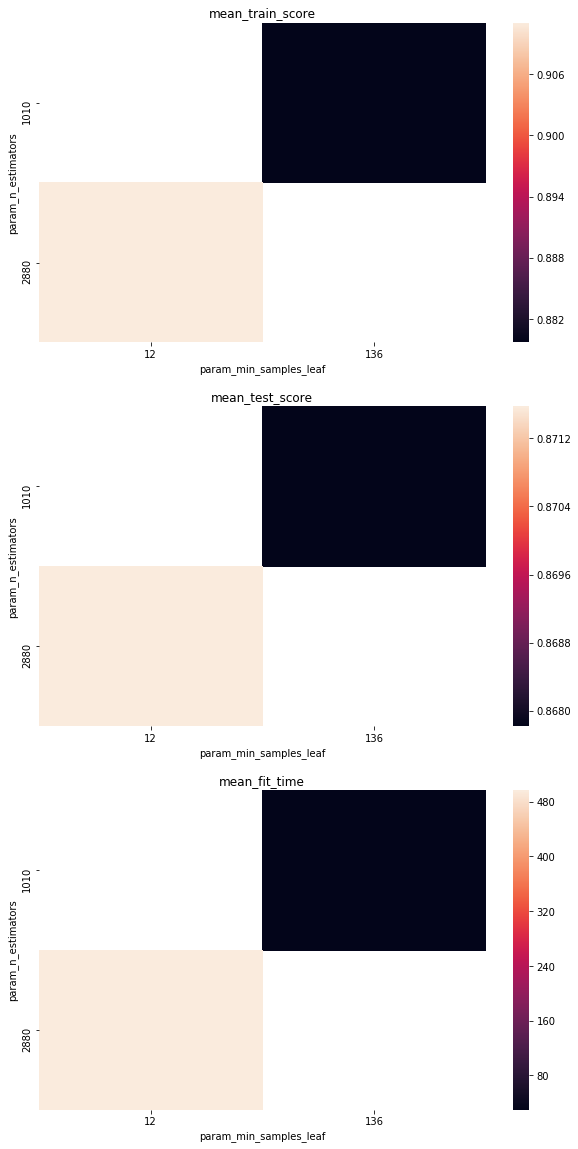


param_n_estimators and param_bootstrap


<Figure size 432x288 with 0 Axes>

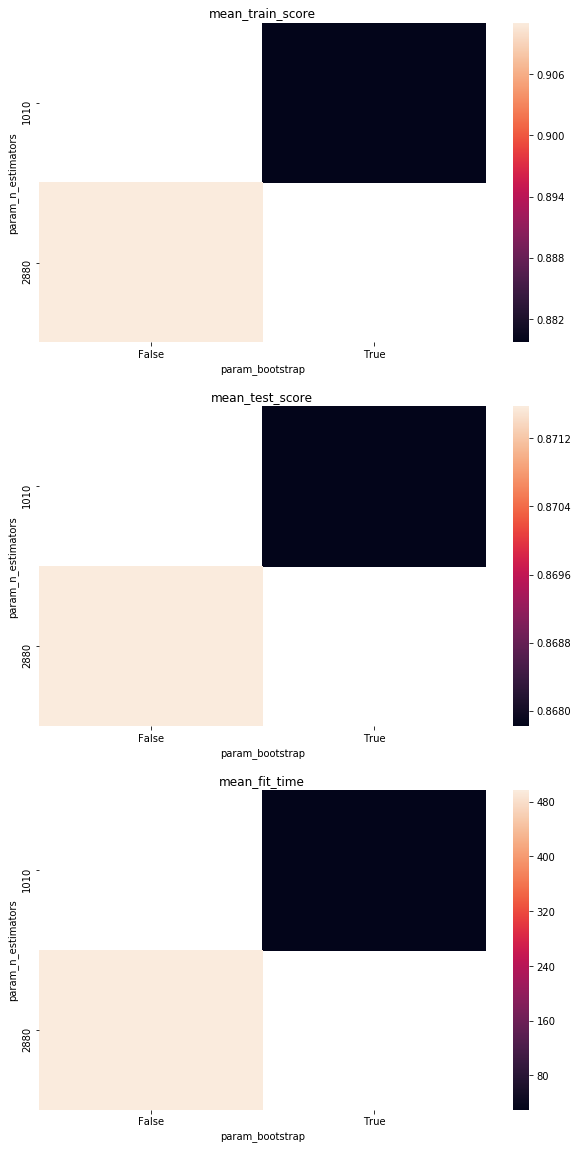


param_max_features and param_max_depth


<Figure size 432x288 with 0 Axes>

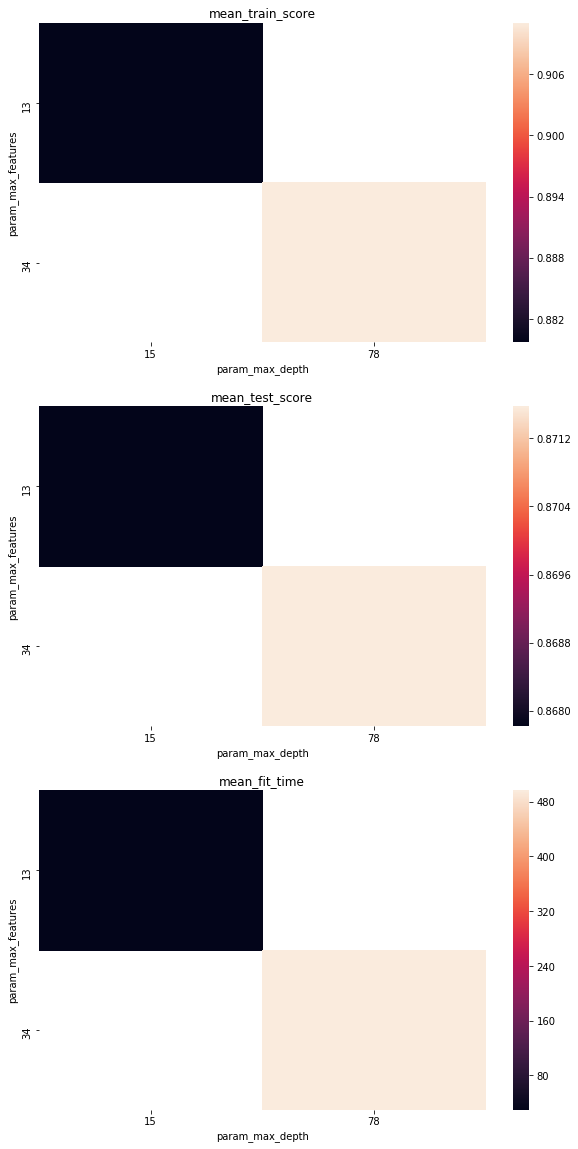


param_max_features and param_min_samples_split


<Figure size 432x288 with 0 Axes>

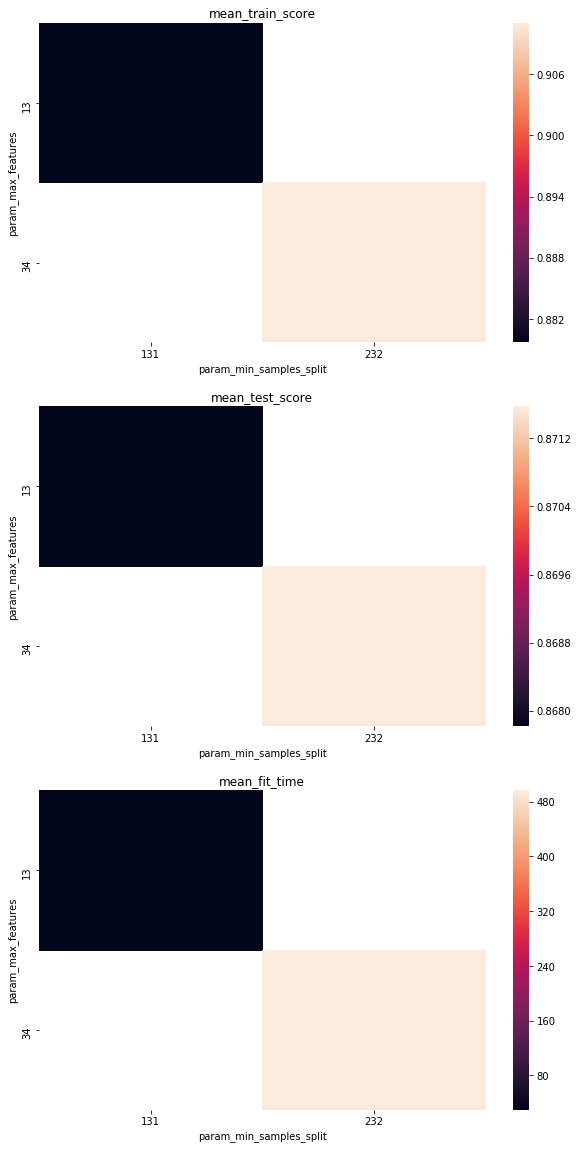


param_max_features and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

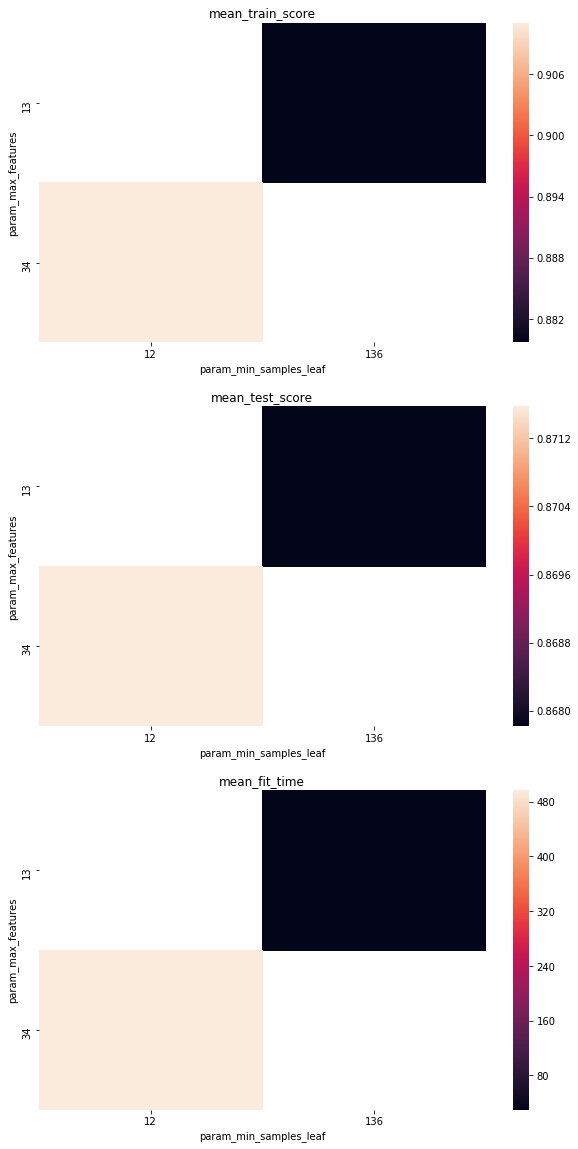


param_max_features and param_bootstrap


<Figure size 432x288 with 0 Axes>

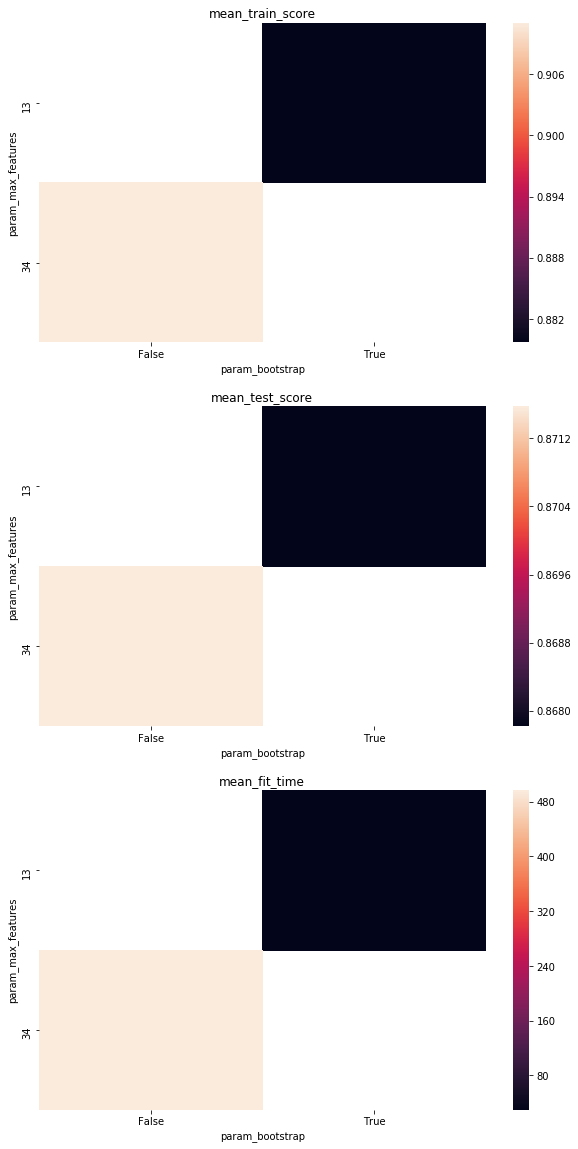


param_max_depth and param_min_samples_split


<Figure size 432x288 with 0 Axes>

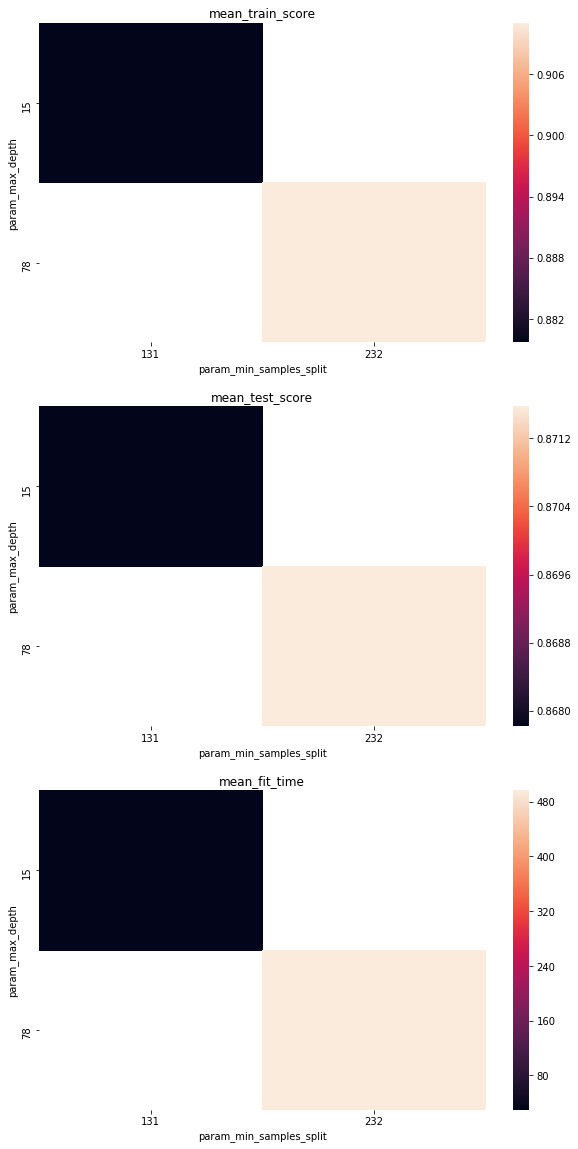


param_max_depth and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

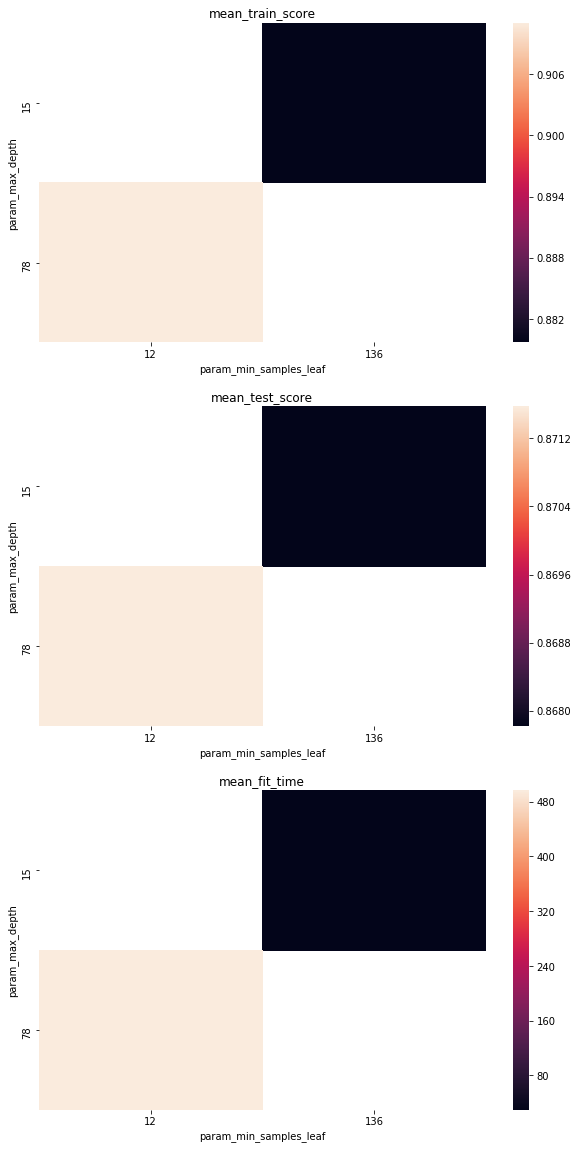


param_max_depth and param_bootstrap


<Figure size 432x288 with 0 Axes>

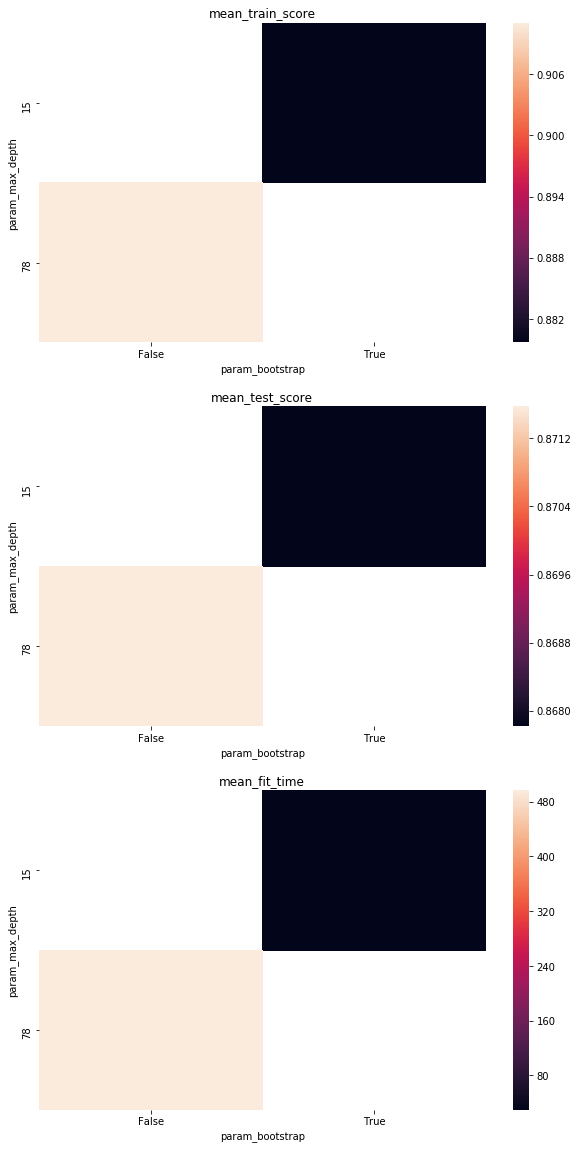


param_min_samples_split and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

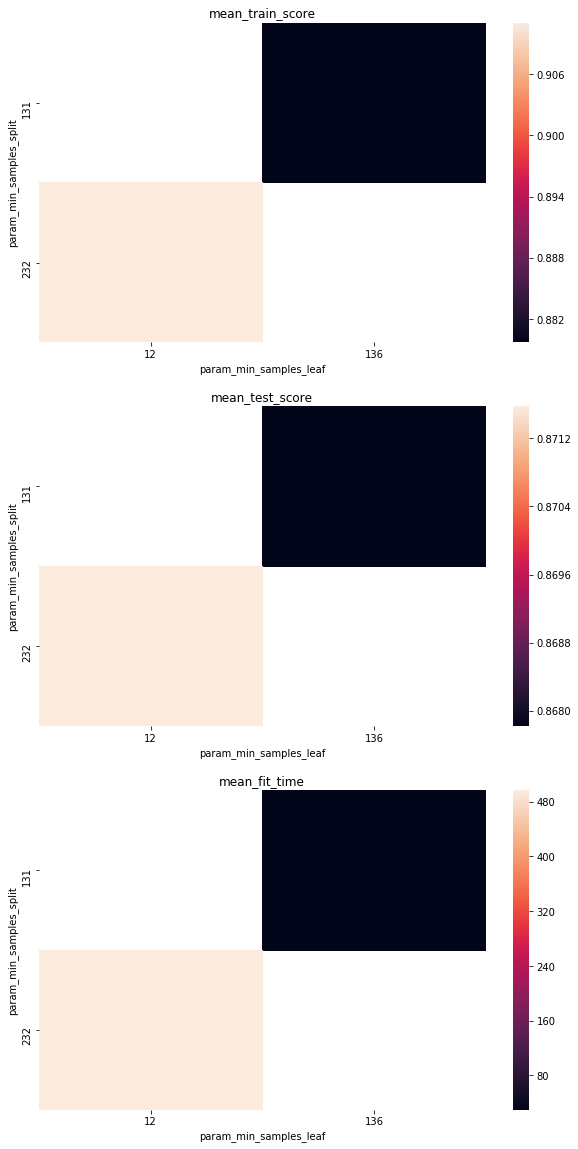


param_min_samples_split and param_bootstrap


<Figure size 432x288 with 0 Axes>

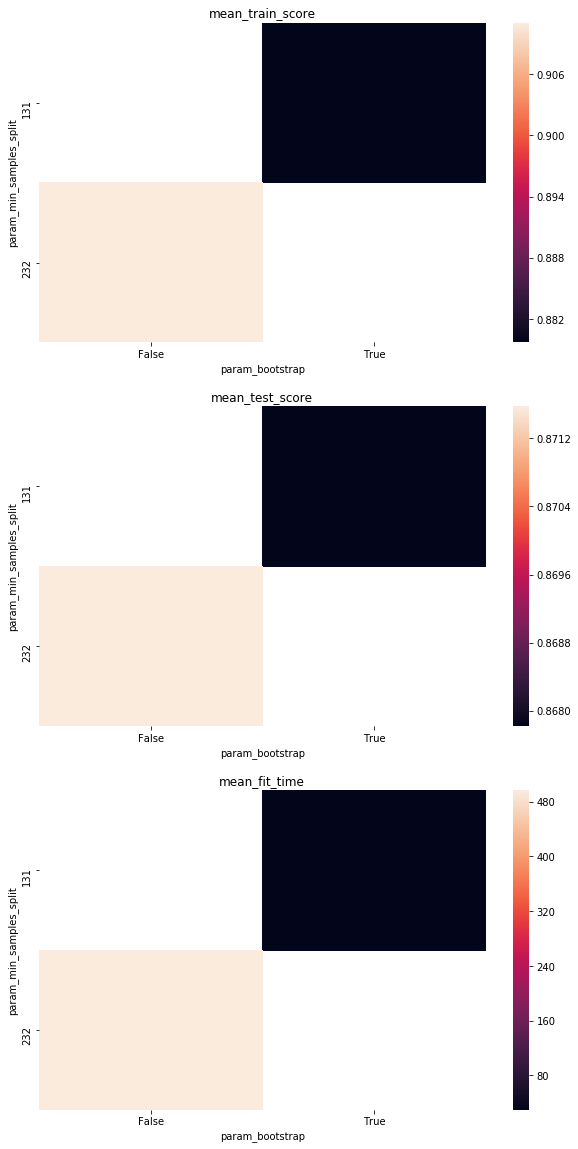


param_min_samples_leaf and param_bootstrap


<Figure size 432x288 with 0 Axes>

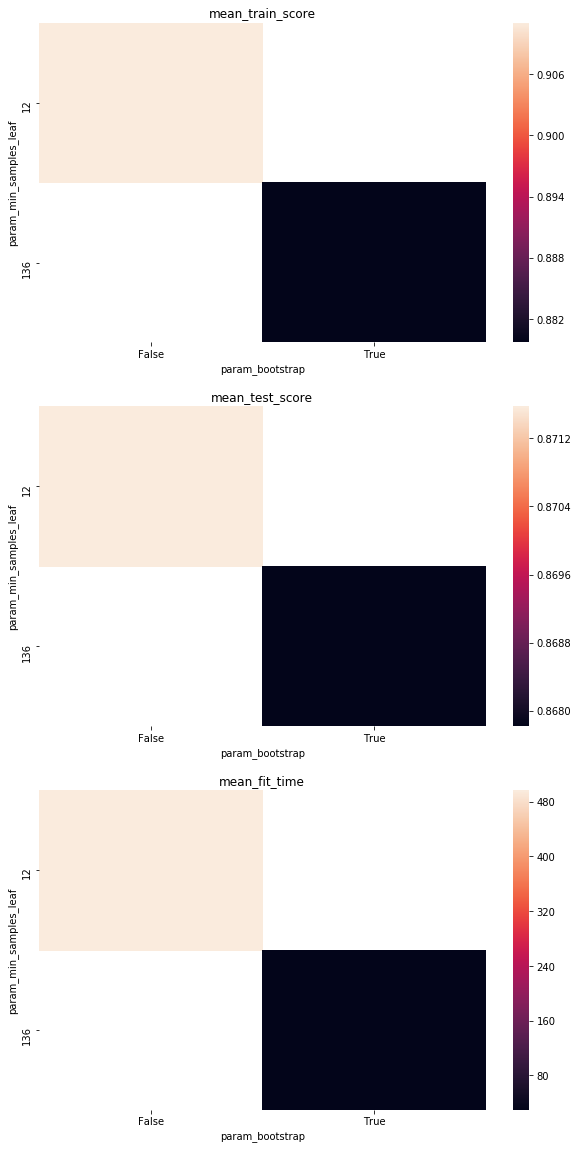

,param_n_estimators,param_max_features,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_bootstrap,mean_train_score,mean_test_score,mean_fit_time
0,2880,34,78,232,12,False,0.911030,0.871573,496.972565
1,1010,13,15,131,136,True,0.879708,0.867821,29.738109


<Figure size 432x288 with 0 Axes>

In [19]:
# Visualise the results to find optimal hyperparameters
rf_results = visualise_results(random_grid=rf_random_grid, random_search_model=rf_random_search_model,
                            training_score='mean_train_score', cv_score='mean_test_score', fit_time='mean_fit_time')
rf_results

In [ ]:
# Re-run on best parameters and save model
final_run(random_search_model=rf_random_search_model,
          classifier=RandomForestClassifier,
          model_name='random_forest')